In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import chi2_contingency, ttest_ind
from tqdm import tqdm
from sklearn.inspection import permutation_importance
import shap


In [1]:
file_path = "../data/300k_dataset.csv"
df = pd.read_csv(file_path)

X = df.drop(["checked", 'Ja', 'Nee'], axis=1)
y = df["checked"]

def distribution_analysis(X):
    stats = X.describe().T
    stats['skewness'] = X.skew()
    stats['kurtosis'] = X.kurtosis()
    return stats

def correlation_analysis(X, y):
    mi_scores = mutual_info_classif(X, y, random_state=0)
    return pd.DataFrame({
        'Feature': X.columns,
        'Mutual_Info': mi_scores
    }).sort_values(by='Mutual_Info', ascending=False)

def statistical_tests(X, y):
    results = []
    for col in tqdm(X.columns, desc="Statistical Test"):
        if X[col].nunique() > 2:  # 连续变量
            t_stat, p_value = ttest_ind(X[col][y == 1], X[col][y == 0], equal_var=False)
        else:  # 类别变量
            contingency_table = pd.crosstab(X[col], y)
            _, p_value, _, _ = chi2_contingency(contingency_table)
        results.append((col, p_value))
    return pd.DataFrame(results, columns=['Feature', 'P_value']).sort_values(by='P_value')


def model_analysis(X, y):
    model = RandomForestClassifier(random_state=0)
    model.fit(X, y)
    importance = model.feature_importances_
    return pd.DataFrame({
        'Feature': X.columns,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)

dist_stats = distribution_analysis(X)
correlation_scores = correlation_analysis(X, y)
stat_tests = statistical_tests(X, y)
model_importance = model_analysis(X, y)



ModuleNotFoundError: No module named 'ace_tools'

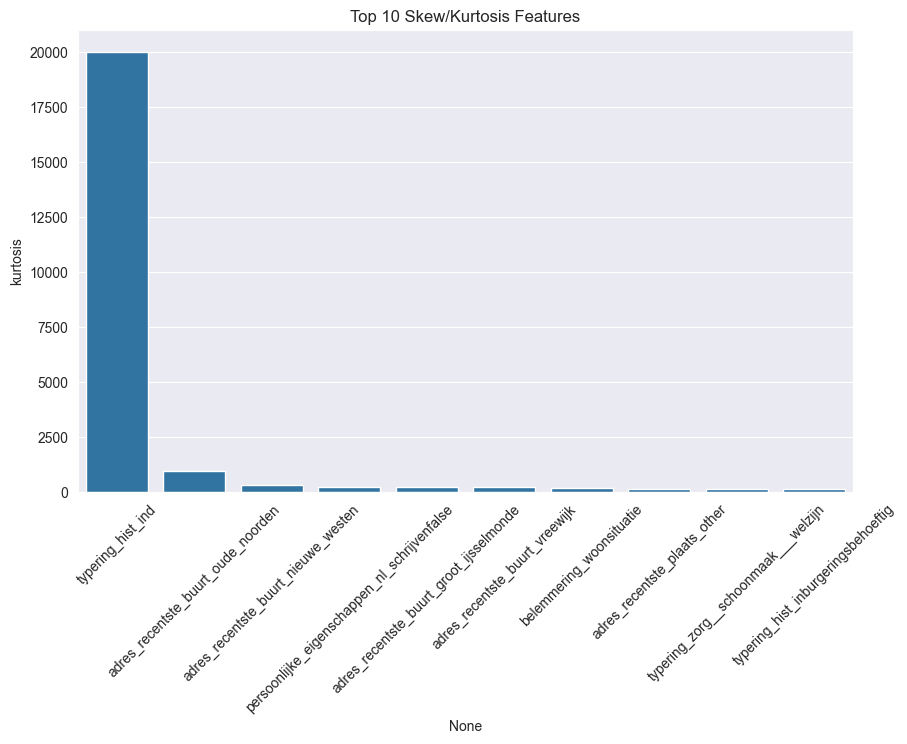

Data has no positive values, and therefore cannot be log-scaled.


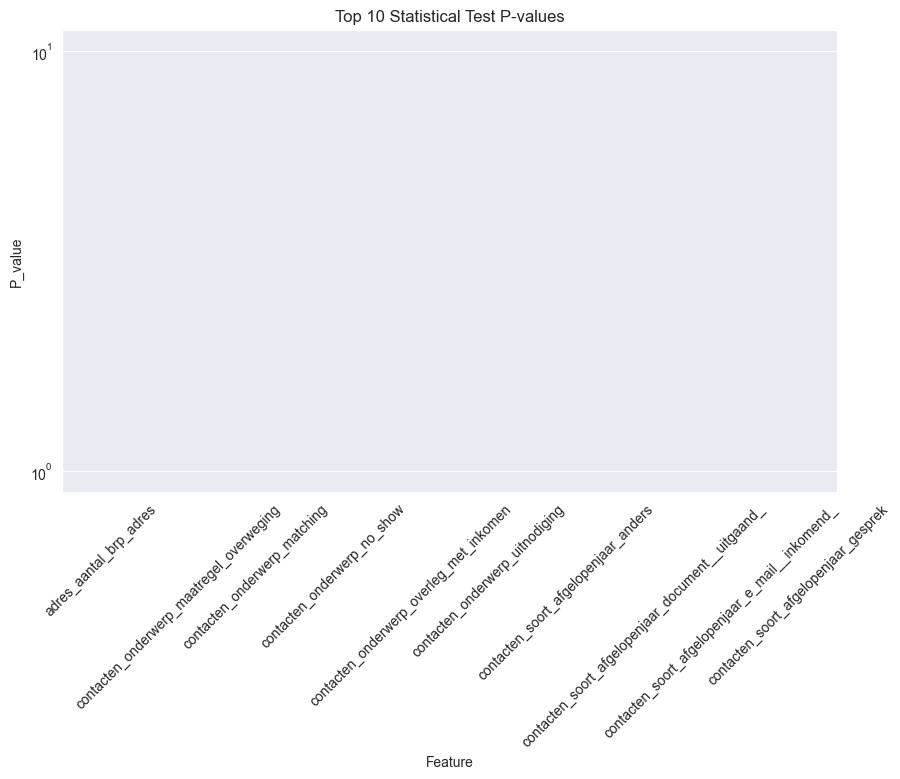

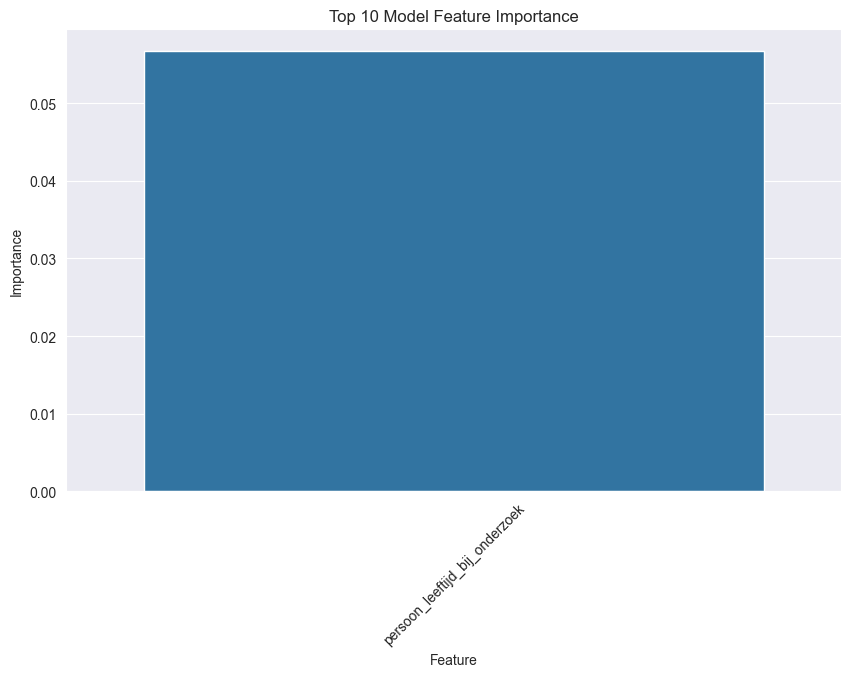

In [6]:
#Most Bias Feature selection
def filter_bias_features(dist_stats, correlation_scores, stat_tests, model_importance):
    significant_dist = dist_stats[(dist_stats['skewness'].abs() > 1) | (dist_stats['kurtosis'] > 3)].nlargest(10, 'kurtosis')
    significant_corr = correlation_scores[correlation_scores['Mutual_Info'] > 0.1].nlargest(10, 'Mutual_Info')
    significant_stats = stat_tests[stat_tests['P_value'] < 0.05].nsmallest(10, 'P_value')
    significant_importance = model_importance[model_importance['Importance'] > 0.05].nlargest(10, 'Importance')

    return significant_dist, significant_corr, significant_stats, significant_importance

def visualize_bias_features(significant_dist, significant_corr, significant_stats, significant_importance):
    import matplotlib.pyplot as plt
    import seaborn as sns

    def plot_data(title, x, y, data, log_scale=False):
        plt.figure(figsize=(10, 6))
        sns.barplot(x=x, y=y, data=data)
        plt.xticks(rotation=45)
        plt.title(title)
        if log_scale:
            plt.yscale("log")
        plt.show()

    # Here we calculating the Skew Kurtosis Feature: https://support.microsoft.com/en-us/office/skew-function-bdf49d86-b1ef-4804-a046-28eaea69c9fa
    if not significant_dist.empty:
        plot_data("Top 10 Skew/Kurtosis Features", significant_dist.index, 'kurtosis', significant_dist)

    if not significant_corr.empty:
        plot_data("Top 10 Mutual Information Scores", 'Feature', 'Mutual_Info', significant_corr)

    if not significant_stats.empty:
        plot_data("Top 10 Statistical Test P-values", 'Feature', 'P_value', significant_stats, log_scale=True)

    if not significant_importance.empty:
        plot_data("Top 10 Model Feature Importance", 'Feature', 'Importance', significant_importance)

significant_dist, significant_corr, significant_stats, significant_importance = filter_bias_features(
    dist_stats, correlation_scores, stat_tests, model_importance)

visualize_bias_features(significant_dist, significant_corr, significant_stats, significant_importance)


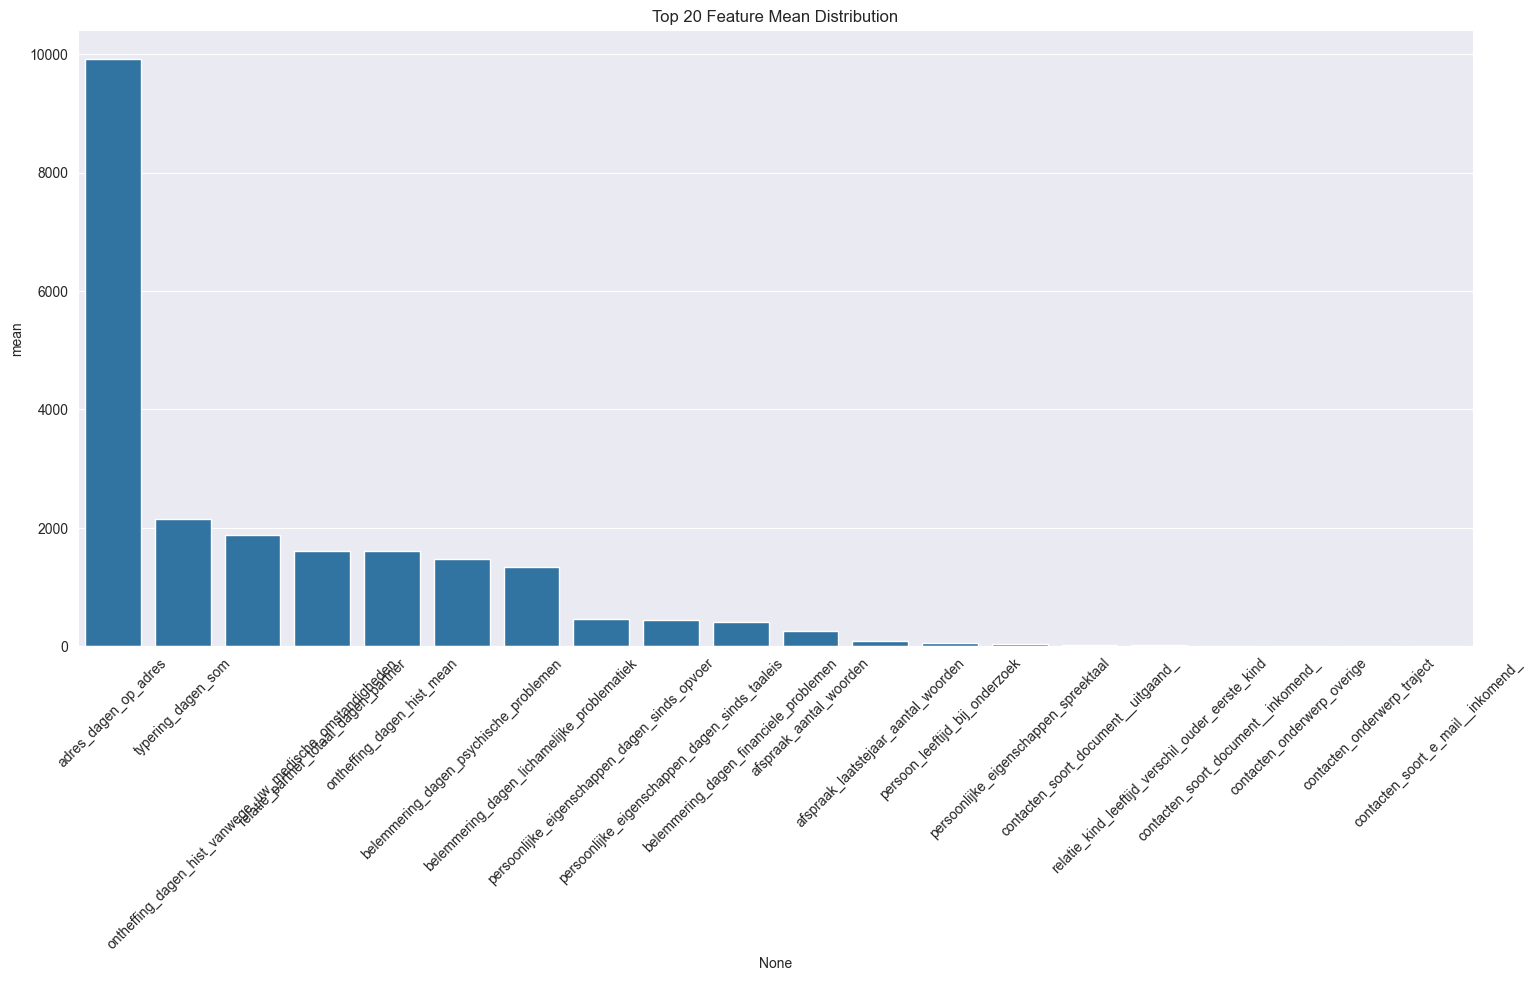

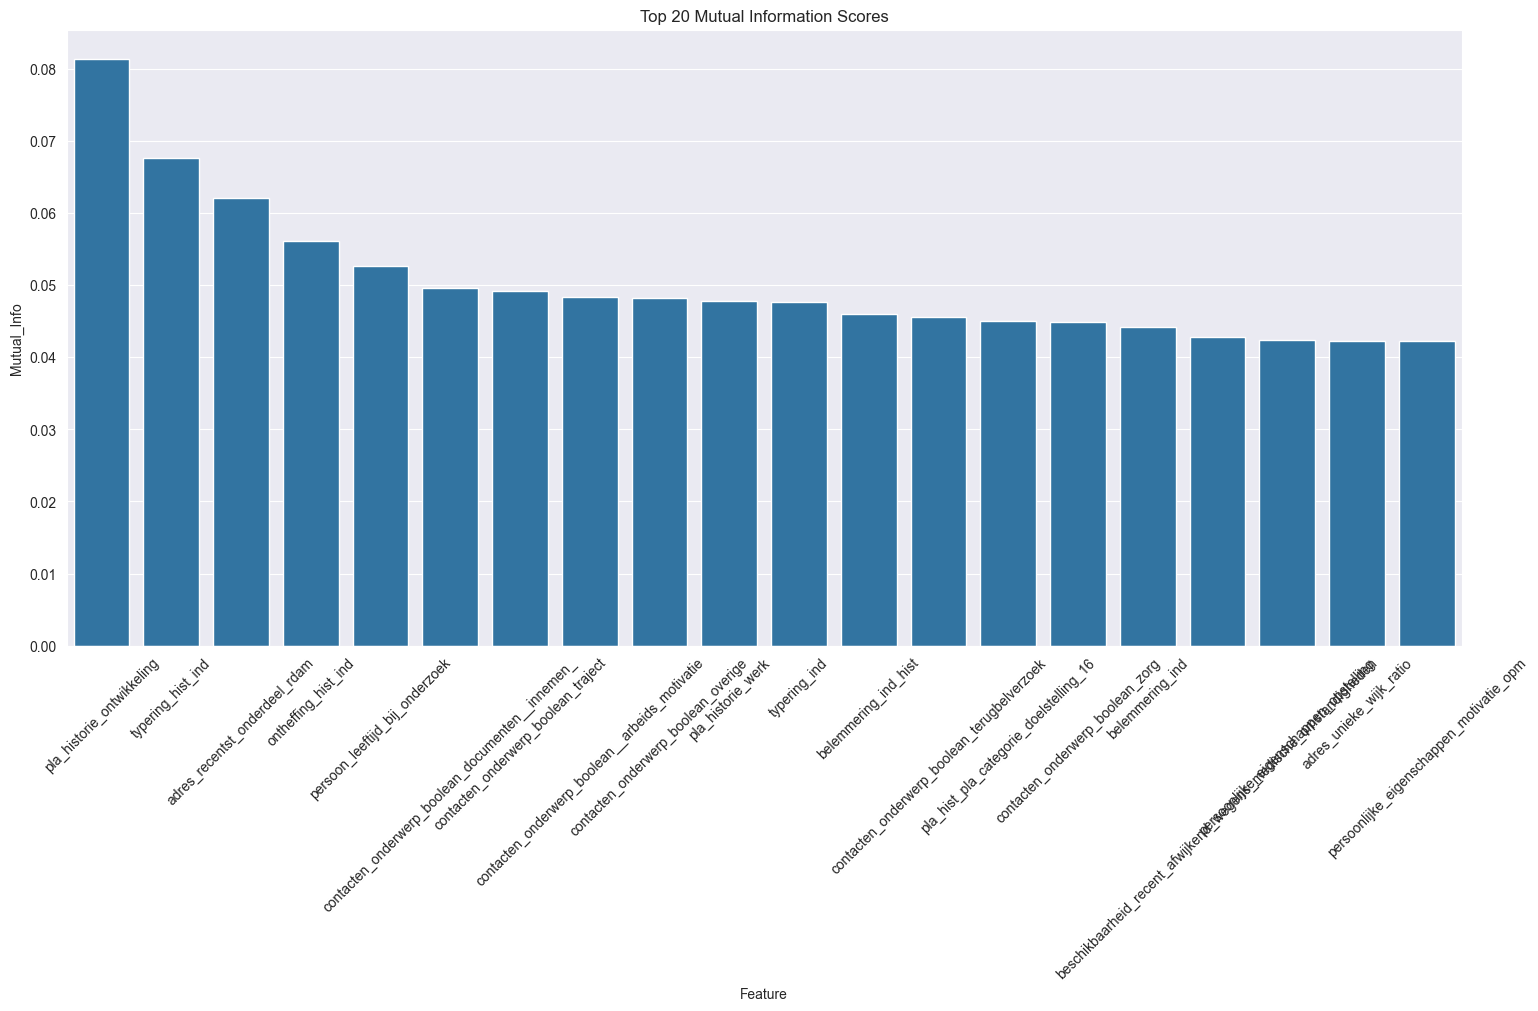

Data has no positive values, and therefore cannot be log-scaled.


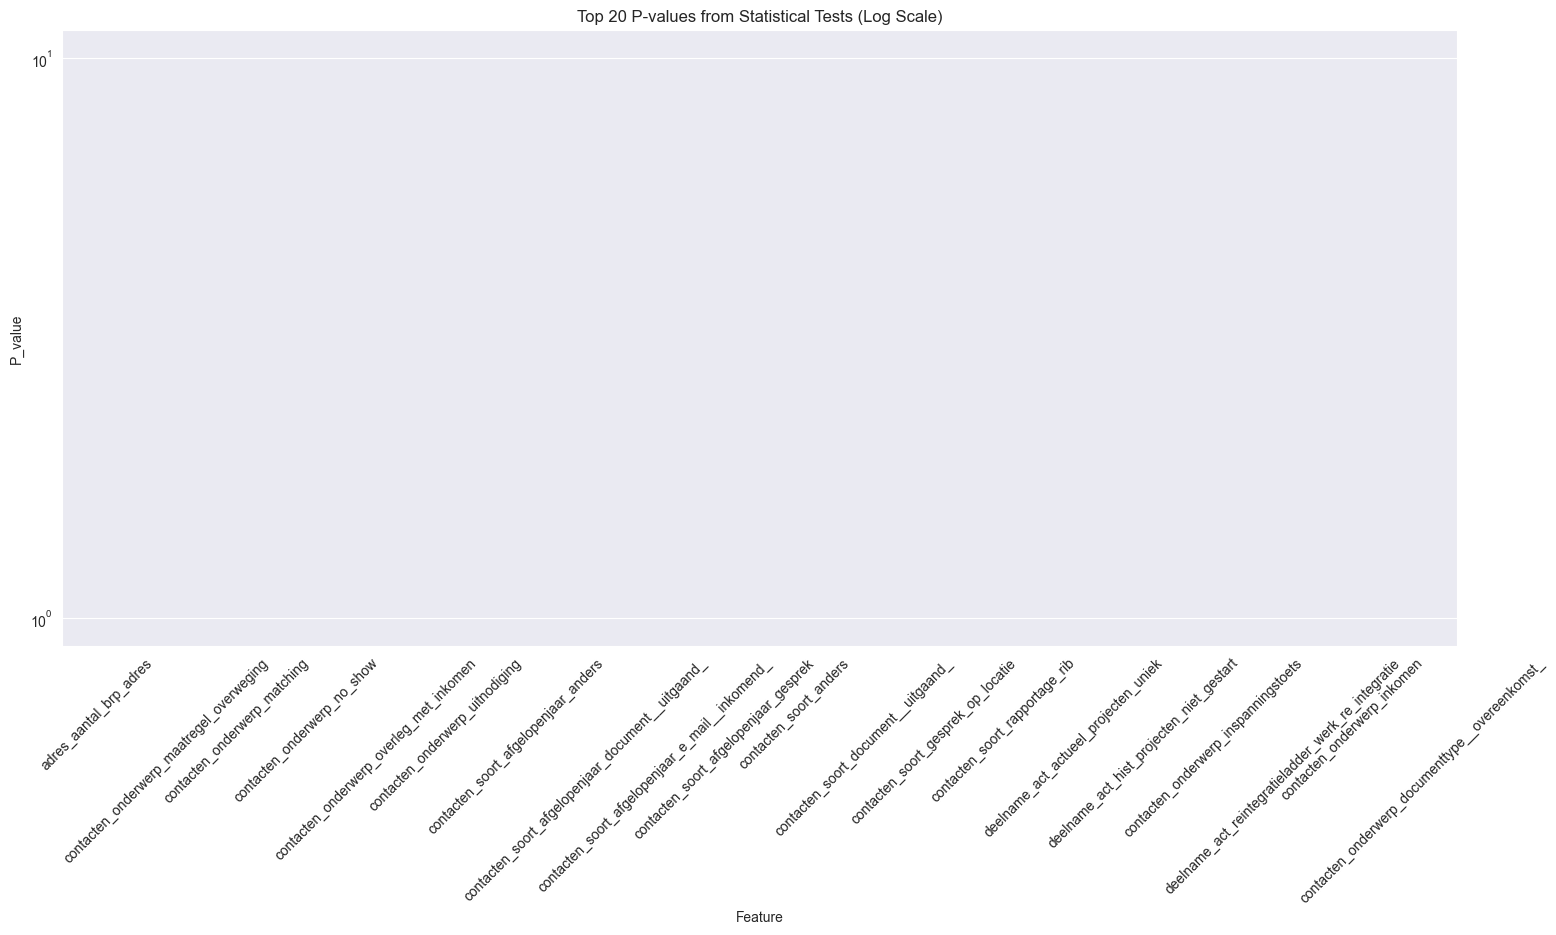

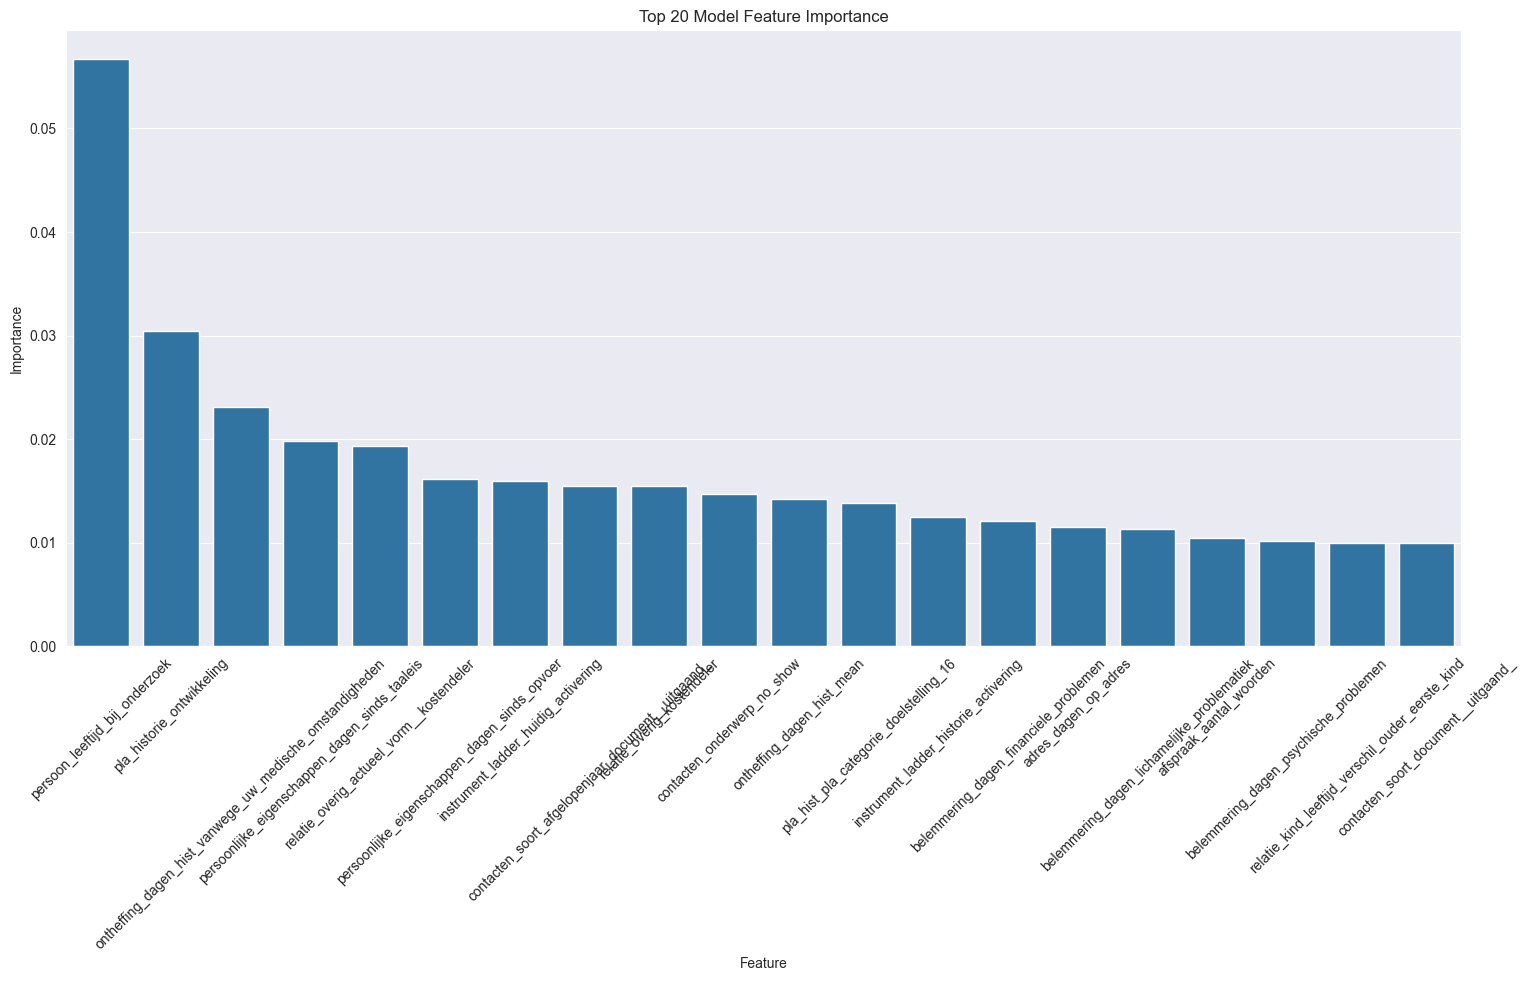

In [9]:
# Visualization
def visualize_distribution(stats, top_n=20):
    plt.figure(figsize=(18, 8))
    top_stats = stats.nlargest(top_n, 'mean')
    sns.barplot(x=top_stats.index, y='mean', data=top_stats)
    plt.xticks(rotation=45)
    plt.title(f"Top {top_n} Feature Mean Distribution")
    plt.show()

def visualize_correlation(correlation_scores, top_n=20):
    plt.figure(figsize=(18, 8))
    top_corr = correlation_scores.nlargest(top_n, 'Mutual_Info')
    sns.barplot(x='Feature', y='Mutual_Info', data=top_corr)
    plt.xticks(rotation=45)
    plt.title(f"Top {top_n} Mutual Information Scores")
    plt.show()

def visualize_stat_tests(stat_tests, top_n=20):
    plt.figure(figsize=(18, 8))
    top_stats = stat_tests.nsmallest(top_n, 'P_value')
    sns.barplot(x='Feature', y='P_value', data=top_stats)
    plt.xticks(rotation=45)
    plt.title(f"Top {top_n} P-values from Statistical Tests (Log Scale)")
    plt.yscale("log")
    plt.show()

def visualize_model_importance(model_importance, top_n=20):
    plt.figure(figsize=(18, 8))
    top_importance = model_importance.nlargest(top_n, 'Importance')
    sns.barplot(x='Feature', y='Importance', data=top_importance)
    plt.xticks(rotation=45)
    plt.title(f"Top {top_n} Model Feature Importance")
    plt.show()

visualize_distribution(dist_stats)
visualize_correlation(correlation_scores)
visualize_stat_tests(stat_tests)
visualize_model_importance(model_importance)


In [11]:
model = RandomForestClassifier(random_state=0)
model.fit(X, y)

def permutation_importance_analysis(model, X, y):
    with tqdm(total=len(X.columns), desc="Calculation Permutation Importance") as pbar:
        perm_importance = permutation_importance(
            model, X, y, n_repeats=30, random_state=0
        )
        perm_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': perm_importance.importances_mean,
            'Std': perm_importance.importances_std
        }).sort_values(by='Importance', ascending=False)
        pbar.update(len(X.columns))

    plt.figure(figsize=(10, 6))
    plt.barh(perm_df['Feature'], perm_df['Importance'])
    plt.title("Permutation Feature Importance")
    plt.xlabel("Mean Importance")
    plt.gca().invert_yaxis()
    plt.show()
    return perm_df

def shap_analysis(model, X):
    explainer = shap.TreeExplainer(model)

    with tqdm(total=len(X), desc="SHAP Calculation") as pbar:
        shap_values = explainer.shap_values(X, check_additivity=False)
        pbar.update(len(X))

    shap.summary_plot(shap_values, X, plot_type="bar", show=False)
    plt.title("SHAP Feature Importance (Global)")
    plt.show()
    shap.summary_plot(shap_values, X, show=False)
    plt.title("SHAP Summary Plot")
    plt.show()

perm_df = permutation_importance_analysis(model, X, y)
shap_analysis(model, X)



KeyboardInterrupt

